# LightGlue-ONNX Demo
This demo shows how to export LightGlue to ONNX and perform inference with ONNXRuntime.

### Env Install

In [4]:
!pip install torch
!pip install kornia
!pip install onnx
!pip install onnxruntime
!pip install polygraphy
!pip install torchfunc
!pip install torchvision
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install typer
!pip install tensorrt
!pip install nvidia-pyindex 
!pip install nvidia-cuda-runtime-cu12





Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-10.8.0.43-py

In [ ]:
## auto reloads imports so you dont need to restart kernal
%load_ext autoreload
%autoreload 2


In [2]:
from export import export_onnx
from infer import infer
import time

/home/sam/code/LightGlue-ONNX/lightglue_onnx/lightglue.py:13: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


## ONNX Export
In this example we use SuperPoint features combined with LightGlue.

In [9]:
extractor_type = "superpoint"  # "disk"
extractor_path = f"weights/{extractor_type}.onnx"
lightglue_path = f"weights/{extractor_type}_pipline_sam_lightglue.onnx"

export_onnx(
    extractor_type=extractor_type,
    extractor_path=None,  #extractor_path
    lightglue_path=lightglue_path,
    dynamic=True,  # for dynamic image size
    max_num_keypoints=None,
    end2end=True,
)

Loaded SuperPoint model
Loaded LightGlue model


/home/sam/code/LightGlue-ONNX/lightglue_onnx/end2end.py:49: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  size = torch.tensor([w, h], dtype=torch.float32, device=kpts.device)
/home/sam/code/LightGlue-ONNX/lightglue_onnx/end2end.py:49: TracerWarning: Converting a tensor to a Python float might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  size = torch.tensor([w, h], dtype=torch.float32, device=kpts.device)


## ONNX Inference

/home/sam/.local/lib/python3.10/site-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


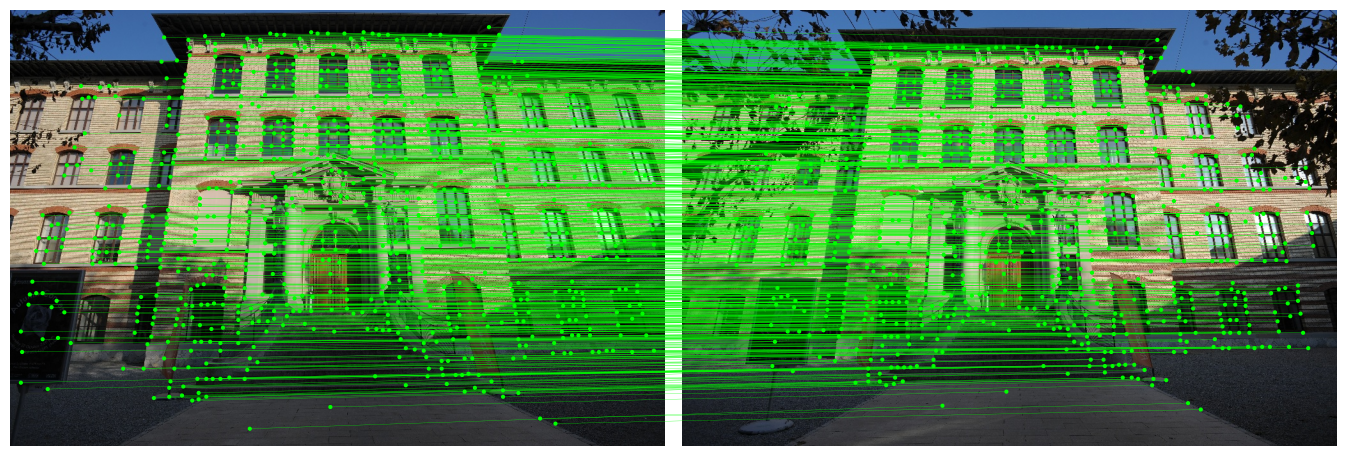

In [4]:
m_kpts0, m_kpts1 = infer(
    #img_paths=["assets/tilt_image.png", "assets/tile_image.png"],
    img_paths=["assets/DSC_0410.JPG", "assets/DSC_0411.JPG"],
    extractor_type=extractor_type,
    extractor_path=extractor_path,
    lightglue_path=lightglue_path,
    img_size=512, #512
    viz=True,
    trt=False,
)

### ALTERNATIVE

In [22]:
from lightglue import LightGlue, SuperPoint
from lightglue.utils import load_image, read_image, numpy_image_to_torch, rbd
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time

device='cpu'

# SuperPoint+LightGlue
extractor = SuperPoint(max_keypoints=3840, detection_threshold=0.0005).eval().to(device)  # load the extractor
matcher = LightGlue(features='superpoint', depth_confidence=0.99, width_confidence=0.99, filter_threshold=0.001).eval().to(device)  # load the matcher

img0 = read_image('assets/sacre_coeur1.jpg')
img1 = read_image('assets/sacre_coeur2.jpg')


start_clock = time.time()

# extract local features
image0 = numpy_image_to_torch(img0).to(device)
feats0 = extractor.extract(image0)

end_clock = time.time()
time_diff = end_clock - start_clock
print(f"Execution Time: {time_diff:.4f} seconds")

start_clock = time.time()

# extract local features
image1 = numpy_image_to_torch(img1).to(device)
feats1 = extractor.extract(image1)

end_clock = time.time()
time_diff = end_clock - start_clock
print(f"Execution Time: {time_diff:.4f} seconds")



# match the features
start_clock = time.time()
matches01 = matcher({'image0': feats0, 'image1': feats1})
feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension


matches = matches01['matches']  # indices with shape (K,2)
print(f"Number of matches: {matches.shape[0]}")
points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

end_clock = time.time()
time_diff = end_clock - start_clock
print(f"Execution Time: {time_diff:.4f} seconds")
        
# Convert points to OpenCV KeyPoints
img0_kpts = [cv2.KeyPoint(p[0], p[1], 1) for p in feats0['keypoints'].cpu().numpy()]
img1_kpts = [cv2.KeyPoint(p[0], p[1], 1) for p in feats1['keypoints'].cpu().numpy()]

# Convert matches
good_matches = [cv2.DMatch(int(m[0]), int(m[1]), 0) for m in matches]

# Draw the matches
matched_image = cv2.drawMatches(
    img0, img0_kpts,  # Image 1 and its keypoints
    img1, img1_kpts,  # Image 2 and its keypoints
    good_matches,  # Matches between keypoints
    None,  # Output image, pass None to create automatically
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS  # Draw only matched points
)

plt.figure(figsize=(20, 20))
plt.imshow(matched_image)
plt.axis('off')
plt.show()

cv2.imwrite('assets/matched_image_coracao.png', cv2.cvtColor(matched_image, cv2.COLOR_RGB2BGR))


Execution Time: 1.8436 seconds
Execution Time: 1.6249 seconds
Number of matches: 460
Execution Time: 3.2030 seconds


RuntimeError: Numpy is not available

### Pipeline onnx export dynamic batch

fp16 can also be enabled

In [4]:
## dynamo export

from dynamo import export

from lightglue_dynamo.config import Extractor

export(
    extractor_type=Extractor.superpoint,  # Use the enum value instead of a string
    output="weights/superpoint_pipline_sam_lightglue_dynamic_batch.onnx",
    batch_size=0,
    height=1024,
    width=1024,
    num_keypoints=1024,
    fuse_multi_head_attention=False,
    opset=17,
    fp16=False
)

/home/sam/code/LightGlue-ONNX/lightglue_dynamo/models/superpoint.py:161: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  one = torch.tensor(1)  # Always constant, safe to ignore warning.
/home/sam/.local/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:5383: UserWarning: Exporting aten::index operator of advanced indexing in opset 17 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


Successfully exported model to weights/superpoint_pipline_sam_lightglue_dynamic_batch.onnx


### TensorRT dynamic batch

here you set prefered batch for optimisation 



    min=(2, 3, 1024, 1024),  # min batch=1
    opt=(4, 3, 1024, 1024),   # optimal batch=4
    max=(8, 3, 1024, 1024)    # max batch=8

not yet tested successfuly

In [1]:

from polygraphy.backend.trt import EngineFromNetwork, NetworkFromOnnxPath, Profile, TrtRunner
from polygraphy.backend.trt import (
    CreateConfig, 
    EngineFromNetwork,
    NetworkFromOnnxPath,
    Profile,
    TrtRunner
)


onnx_path = "weights/superpoint_pipline_sam_lightglue_dynamic_batch.onnx"
engine_path = "weights/superpoint_pipline_sam_lightglue_dynamic_batch.engine"


profile = Profile()
profile.add(
    "images", 
    min=(2, 3, 1024, 1024),  # min batch=1
    opt=(4, 3, 1024, 1024),   # optimal batch=4
    max=(8, 3, 1024, 1024)    # max batch=8
)

build_engine = EngineFromNetwork(
    NetworkFromOnnxPath(onnx_path),
    config=CreateConfig(
        fp16=False,
        profiles=[profile]
    )
)

# Save the engine for later use
with open(engine_path, "wb") as f:
    f.write(build_engine())


: 

### ALTERNATIVE ONNX

onnx full pipeline single batch


In [5]:
import numpy as np
import cv2
import time
import onnxruntime as ort
from lightglue_dynamo import viz
from lightglue_dynamo.preprocessors import SuperPointPreprocessor

#model_path = "weights/superpoint_lightglue_pipeline.fp16.onnx"
model_path = "weights/superpoint_pipline_sam_lightglue2.onnx"
output_path = "matches_onnx.png"
width = 1024
height = 1024
fp16 = False
profile = True
device = "cpu"

#raw_images = [cv2.resize(cv2.imread(str(i)), (width, height)) for i in raw_images]

img1 = cv2.imread('assets/sacre_coeur1.jpg')
img2 = cv2.imread('assets/sacre_coeur2.jpg')

img1 = cv2.resize(img1, (width, height))
img2 = cv2.resize(img2, (width, height))
raw_images = [img1, img2]
images = np.stack(raw_images)
images = SuperPointPreprocessor.preprocess(images) #deals with batching
images = images.astype(np.float16 if fp16 and device != "tensorrt" else np.float32)
session_options = ort.SessionOptions()
#session_options.enable_profiling = profile
providers = [("CPUExecutionProvider", {})]
if device == "cuda":
    providers.insert(0, ("CUDAExecutionProvider", {}))
elif device == "tensorrt":
    providers.insert(0, ("CUDAExecutionProvider", {}))
    providers.insert(
        0,
        (
            "TensorrtExecutionProvider",
            {
                "trt_engine_cache_enable": True,
                "trt_engine_cache_path": "weights/.trtcache_engines",
                "trt_timing_cache_enable": True,
                "trt_timing_cache_path": "weights/.trtcache_timings",
                "trt_fp16_enable": fp16,
            },
        ),
    )
elif device == "openvino":
    providers.insert(0, ("OpenVINOExecutionProvider", {}))
session = ort.InferenceSession(model_path, session_options, providers)
for _ in range(4 if profile else 1):
    
    try:
        start_clock = time.time()
        

        keypoints, matches, mscores = session.run(None, {"images": images})
        matched_points0 = keypoints[0][matches[..., 1]]
        matched_points1 = keypoints[1][matches[..., 2]]
        end_clock = time.time()
        time_diff = end_clock - start_clock
        print(f"Execution Time: {time_diff:.4f} seconds")
    #exception oom error  
    except MemoryError as e:
        print(f'OOM error encountered: {e}')
        continue

viz.plot_images(raw_images)
viz.plot_matches(matched_points0, matched_points1, color="lime", lw=0.2)
if output_path is None:
    viz.plt.show()
else:
    viz.save_plot(output_path)

InvalidArgument: [ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Got invalid dimensions for input: images for the following indices
 index: 0 Got: 2 Expected: 4
 Please fix either the inputs/outputs or the model.

### Onnx inference full pipeline dynamic batching 

Execution Time: 4.6189 seconds
Execution Time: 4.4658 seconds
Execution Time: 3.9214 seconds
Execution Time: 4.1182 seconds


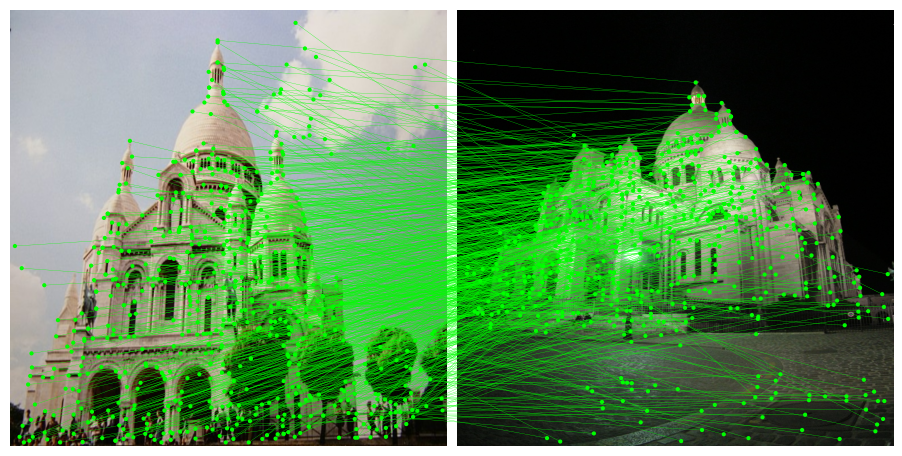

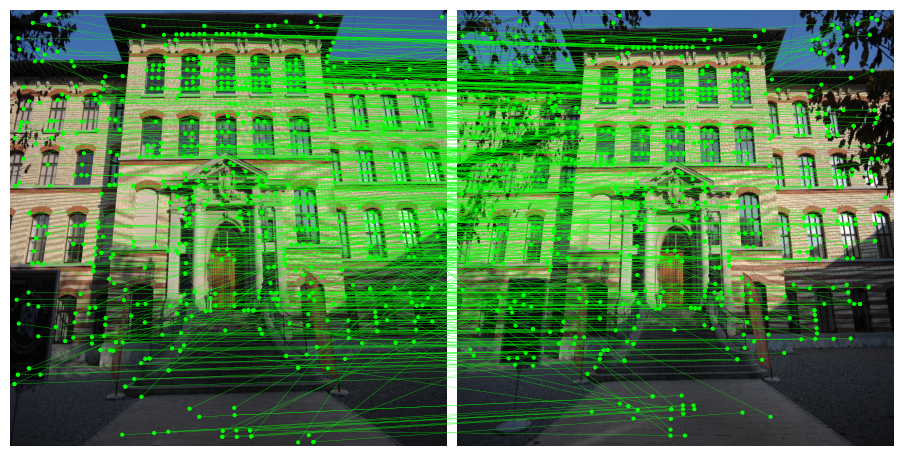

In [5]:
##Batching 

import numpy as np
import cv2
import time
import onnxruntime as ort
from lightglue_dynamo import viz
from lightglue_dynamo.preprocessors import SuperPointPreprocessor

model_path = "weights/superpoint_pipline_sam_lightglue_dynamic_batch.onnx"
#model_path = "weights/superpoint_pipline_sam_lightglue2.onnx"
output_path = "matches_onnx.png"
width = 1024
height = 1024
fp16 = False
profile = True
device = "cpu"

# List of image files
image_files = [
    'assets/sacre_coeur1.jpg',
    'assets/sacre_coeur2.jpg', 
    'assets/DSC_0410.JPG',
    'assets/DSC_0411.JPG'
]
batch_size = len(image_files)


if batch_size % 2 != 0:
    raise ValueError("Batch size must be a multiple of 2 for pairwise matching")

raw_images = []
for img_file in image_files:
    img = cv2.imread(img_file)
    if img is not None:
        img = cv2.resize(img, (width, height))
        raw_images.append(img)
    else:
        print(f"Warning: Could not read image {img_file}")


images = np.stack(raw_images)
images = SuperPointPreprocessor.preprocess(images) #deals with batching
images = images.astype(np.float16 if fp16 and device != "tensorrt" else np.float32)
session_options = ort.SessionOptions()
#session_options.enable_profiling = profile
providers = [("CPUExecutionProvider", {})]
if device == "cuda":
    providers.insert(0, ("CUDAExecutionProvider", {}))
elif device == "tensorrt":
    providers.insert(0, ("CUDAExecutionProvider", {}))
    providers.insert(
        0,
        (
            "TensorrtExecutionProvider",
            {
                "trt_engine_cache_enable": True,
                "trt_engine_cache_path": "weights/.trtcache_engines",
                "trt_timing_cache_enable": True,
                "trt_timing_cache_path": "weights/.trtcache_timings",
                "trt_fp16_enable": fp16,
            },
        ),
    )
elif device == "openvino":
    providers.insert(0, ("OpenVINOExecutionProvider", {}))
session = ort.InferenceSession(model_path, session_options, providers)
matched_points0 = [];
matched_points1 = [];
for _ in range(4 if profile else 1):
    
    try:
        start_clock = time.time()
        

        keypoints, matches, mscores = session.run(None, {"images": images})

        matched_points = []
        for i in range(0, batch_size, 2):
            matched_points0.append(keypoints[i][matches[..., 1]])  # Image i keypoints
            matched_points1.append(keypoints[i+1][matches[..., 2]]) 

        end_clock = time.time()
        time_diff = end_clock - start_clock
        print(f"Execution Time: {time_diff:.4f} seconds")
    #exception oom error  
    except MemoryError as e:
        print(f'OOM error encountered: {e}')
        continue

# Split raw images into pairs
img_pairs = [(raw_images[i], raw_images[i+1]) for i in range(0, len(raw_images)-1, 2)]

# Plot all pairs
for i in range(int(batch_size/2)):
    viz.plot_images([img_pairs[i][0], img_pairs[i][1]])
    viz.plot_matches(matched_points0[i], matched_points1[i], color="lime", lw=0.2)


if output_path is None:
    viz.plt.show()
else:
    viz.save_plot(output_path)

Execution Time: 3.5253 seconds
Execution Time: 3.6161 seconds
Execution Time: 3.2886 seconds
Execution Time: 3.2305 seconds


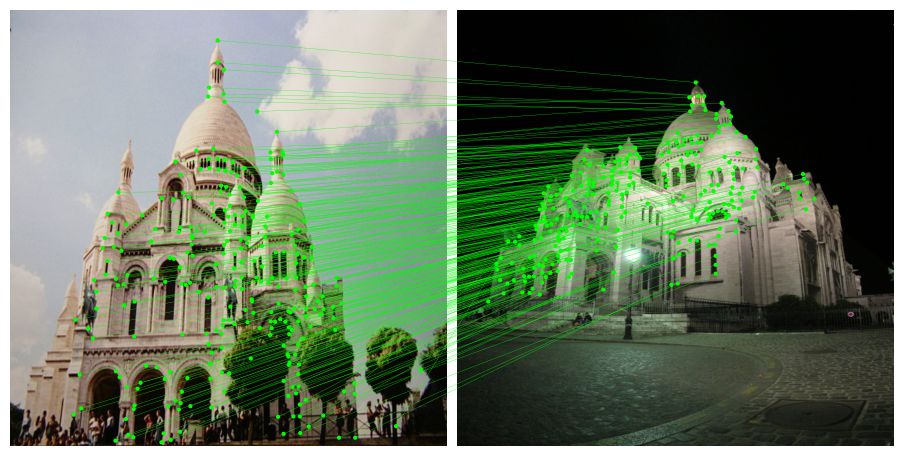

In [6]:
import numpy as np
import cv2
import time
import onnxruntime as ort
from lightglue_dynamo import viz
from lightglue_dynamo.preprocessors import SuperPointPreprocessor

#model_path = "weights/superpoint_lightglue_pipeline.fp16.onnx"
model_path = "weights/superpoint_pipline_sam_lightglue2.onnx"
output_path = "matches_onnx.png"
width = 1024
height = 1024
fp16 = False
profile = True
device = "cpu"

#raw_images = [cv2.resize(cv2.imread(str(i)), (width, height)) for i in raw_images]

img1 = cv2.imread('assets/sacre_coeur1.jpg')
img2 = cv2.imread('assets/sacre_coeur2.jpg')

img1 = cv2.resize(img1, (width, height))
img2 = cv2.resize(img2, (width, height))
raw_images = [img1, img2]
images = np.stack(raw_images)
images = SuperPointPreprocessor.preprocess(images)
images = images.astype(np.float16 if fp16 and device != "tensorrt" else np.float32)
session_options = ort.SessionOptions()
#session_options.enable_profiling = profile
providers = [("CPUExecutionProvider", {})]
if device == "cuda":
    providers.insert(0, ("CUDAExecutionProvider", {}))
elif device == "tensorrt":
    providers.insert(0, ("CUDAExecutionProvider", {}))
    providers.insert(
        0,
        (
            "TensorrtExecutionProvider",
            {
                "trt_engine_cache_enable": True,
                "trt_engine_cache_path": "weights/.trtcache_engines",
                "trt_timing_cache_enable": True,
                "trt_timing_cache_path": "weights/.trtcache_timings",
                "trt_fp16_enable": fp16,
            },
        ),
    )
elif device == "openvino":
    providers.insert(0, ("OpenVINOExecutionProvider", {}))
session = ort.InferenceSession(model_path, session_options, providers)
for _ in range(4 if profile else 1):
    
    try:
        start_clock = time.time()
        

        keypoints, matches, mscores = session.run(None, {"images": images})
        matched_points0 = keypoints[0][matches[..., 1]]
        matched_points1 = keypoints[1][matches[..., 2]]
        end_clock = time.time()
        time_diff = end_clock - start_clock
        print(f"Execution Time: {time_diff:.4f} seconds")
    #exception oom error  
    except MemoryError as e:
        print(f'OOM error encountered: {e}')
        continue

viz.plot_images(raw_images)
viz.plot_matches(matched_points0, matched_points1, color="lime", lw=0.2)
if output_path is None:
    viz.plt.show()
else:
    viz.save_plot(output_path)

### ALTERNATIVE POLYGRAPHY

In [25]:
import numpy as np
import cv2
import typer
from polygraphy.backend.common import BytesFromPath
from polygraphy.backend.trt import (
    EngineFromBytes,
    TrtRunner,
)
from lightglue_dynamo import viz
from lightglue_dynamo.preprocessors import SuperPointPreprocessor

model_path = "weights/superpoint_lightglue_pipeline.fp16.engine"
output_path = "matches_polygraphy.png"
width = 1024
height = 1024
fp16 = True
profile = True

img1 = cv2.imread('assets/sacre_coeur1.jpg')
img2 = cv2.imread('assets/sacre_coeur2.jpg')
img1 = cv2.resize(img1, (width, height))
img2 = cv2.resize(img2, (width, height))
raw_images = [img1, img2]
images = np.stack(raw_images)
images = SuperPointPreprocessor.preprocess(images)
images = images.astype(np.float16 if fp16 else np.float32)
# Build TensorRT engine
build_engine = EngineFromBytes(BytesFromPath(str(model_path)))
runner = TrtRunner(build_engine)
runner.activate()
        
for _ in range(10 if profile else 1):  # Warm-up if profiling
    outputs = runner.infer(feed_dict={"images": images})
    keypoints, matches, mscores = outputs["keypoints"], outputs["matches"], outputs["mscores"]  # noqa: F841
    print(f"Matches size: {matches.shape}")
        
    if profile:
        typer.echo(f"Inference Time: {runner.last_inference_time():.3f} s")
        
viz.plot_images(raw_images)
viz.plot_matches(keypoints[0][matches[..., 1]], keypoints[1][matches[..., 2]], color="lime", lw=0.2)
if output_path is None:
    viz.plt.show()
else:
    viz.save_plot(output_path)

ModuleNotFoundError: No module named 'typer'

In [ ]:
import torch
import time
from torch.func import jvp, jacfwd

# Example: residual function r(x)
def residual_func(x):
    return torch.sin(x.sum()) + torch.arange(10000.0, device=x.device) * x.sum()

# Compute J^T J efficiently without storing J
def compute_jtj_no_storage(residual_func, params):
    N = params.numel()  # Number of parameters
    JTJ = torch.zeros((N, N), dtype=params.dtype, device=params.device)  # Initialize J^T J

    # Standard basis vectors
    identity = torch.eye(N, dtype=params.dtype, device=params.device)
    for i in range(N):
        e_i = identity[i]
        e_i[i] = 1.0

        # Compute J @ e_i (i-th column of J)
        _, jvp_result = jvp(residual_func, (params,), (e_i,))
        
        # Accumulate J^T J for the upper triangular part
        JTJ[i, i:] += (jvp_result.unsqueeze(0) @ jvp_result.unsqueeze(1))[0, :N - i]

    # Copy the upper triangular part to the lower triangular part
    i_lower = torch.tril_indices(N, N, -1)
    JTJ[i_lower[0], i_lower[1]] = JTJ.T[i_lower[0], i_lower[1]]

    return JTJ

# Compare performance and memory usage
def compare_methods(residual_func, params):
    # Measure no-storage method
    start_time = time.perf_counter()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    JTJ_no_storage = compute_jtj_no_storage(residual_func, params)
    elapsed_no_storage = time.perf_counter() - start_time

    # Measure full Jacobian method
    start_time = time.perf_counter()
    torch.cuda.empty_cache() if torch.cuda.is_available() else None
    J = jacfwd(residual_func, argnums=0)(params)
    JTJ_full = J.T @ J
    elapsed_full = time.perf_counter() - start_time

    # Check memory usage (GPU only)
    if torch.cuda.is_available():
        memory_no_storage = torch.cuda.memory_allocated()
        torch.cuda.empty_cache()
        memory_full = torch.cuda.memory_allocated()
        return elapsed_no_storage, elapsed_full, memory_no_storage, memory_full
    else:
        return elapsed_no_storage, elapsed_full

# Example usage
params = torch.randn(500, requires_grad=True)  # 500 parameters (N=500)
results = compare_methods(residual_func, params)

# Display results
if len(results) == 4:  # GPU with memory tracking
    elapsed_no_storage, elapsed_full, memory_no_storage, memory_full = results
    print(f"No-storage method: {elapsed_no_storage:.4f}s, {memory_no_storage / 1e6:.2f} MB")
    print(f"Full Jacobian method: {elapsed_full:.4f}s, {memory_full / 1e6:.2f} MB")
else:  # CPU only
    elapsed_no_storage, elapsed_full = results
    print(f"No-storage method: {elapsed_no_storage:.4f}s")
    print(f"Full Jacobian method: {elapsed_full:.4f}s")